In [24]:
import os
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib import colors
from eofs.xarray import Eof
import tensorflow as tf
import gpflow
import seaborn as sns
import cartopy.crs as ccrs
from utils import *

In [4]:
train_files = ["ssp126", "ssp585", "historical", "1pctCO2", "hist-GHG"]

In [7]:
# Create training and testing arrays
X_train = pd.concat([create_predictor_data(file) for file in train_files])
y_train_dtr = np.vstack([create_predictdand_data(file)['diurnal_temperature_range'].values.reshape(-1, 96 * 144)
                         for file in train_files])

X_test = create_predictor_data('ssp245')
Y_test = xr.open_dataset(data_path + 'outputs_ssp245.nc').compute()
dtr_truth = Y_test["diurnal_temperature_range"].mean('member')

In [8]:
# Drop rows including nans
nan_train_mask = X_train.isna().any(axis=1).values
X_train = X_train.dropna(axis=0, how='any')
y_train_dtr = y_train_dtr[~nan_train_mask]
assert len(X_train) == len(y_train_dtr)

nan_test_mask = X_test.isna().any(axis=1).values
X_test = X_test.dropna(axis=0, how='any')
dtr_truth = dtr_truth[~nan_test_mask]

In [9]:
# Standardize predictor fields requiring standardization (non-EOFs)
train_CO2_mean, train_CO2_std = X_train['CO2'].mean(), X_train['CO2'].std()
train_CH4_mean, train_CH4_std = X_train['CH4'].mean(), X_train['CH4'].std()
train_CO2_5Y_mean, train_CO2_5Y_std = X_train['CO2_5YR'].mean(), X_train['CO2_5YR'].std()

X_train.CO2 = (X_train.CO2 - train_CO2_mean) / train_CO2_std
X_train.CH4 = (X_train.CH4 - train_CH4_mean) / train_CH4_std
X_train.CO2_5YR = (X_train.CO2_5YR - train_CO2_5Y_mean) / train_CO2_5Y_std

X_test.CO2 = (X_test.CO2 - train_CO2_mean) / train_CO2_std
X_test.CH4 = (X_test.CH4 - train_CH4_mean) / train_CH4_std
X_test.CO2_5YR = (X_test.CO2_5YR - train_CO2_5Y_mean) / train_CO2_5Y_std

In [10]:
# Standardize predictand fields
train_dtr_mean, train_dtr_std = y_train_dtr.mean(), y_train_dtr.std()
y_train_dtr = (y_train_dtr - train_dtr_mean) / train_dtr_std

In [11]:
# Make kernel
kernel_CO2 = gpflow.kernels.Linear(active_dims=[0])
kernel_CH4 = gpflow.kernels.Linear(active_dims=[1])

kernel_BC = gpflow.kernels.Linear(active_dims=[2, 3, 4, 5, 6])
kernel_SO2 = gpflow.kernels.Linear(active_dims=[7, 8, 9, 10, 11])

kernel_CO2_5Y = gpflow.kernels.Linear(active_dims=[12])

kernel = kernel_CO2 + kernel_CH4 + kernel_BC + kernel_SO2 + kernel_CO2_5Y

In [13]:
# Make model
np.random.seed(5)
mean = gpflow.mean_functions.Constant()
model = gpflow.models.GPR(data=(X_train.astype(np.float64), 
                                y_train_dtr.astype(np.float64)),
                          kernel=kernel,
                          mean_function=mean)

In [14]:
# Define optimizer
opt = gpflow.optimizers.Scipy()

# Train model
opt.minimize(model.training_loss,
             variables=model.trainable_variables,
             options=dict(disp=True, maxiter=1000))

      fun: 9878975.870154908
 hess_inv: <7x7 LbfgsInvHessProduct with dtype=float64>
      jac: array([-8.20580182e-001, -1.42043118e+000,  3.64685262e+000,
        3.32302203e-236, -4.88301580e-067,  8.88621954e-001,
        4.03187119e+000])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 63
      nit: 45
   status: 0
  success: True
        x: array([ 1.03283883e+03,  3.44416721e-01,  2.31404236e+02, -5.56481544e+02,
       -1.61596406e+02, -4.21713831e-01, -1.68321563e-05])

In [16]:
# predict
standard_posterior_mean, standard_posterior_var = model.predict_y(X_test.values)
posterior_mean = standard_posterior_mean * train_dtr_std + train_dtr_mean
posterior_std = np.sqrt(standard_posterior_var) * train_dtr_std

In [17]:
# put output back into pd.DataFrame format for calculating RMSE/plotting
posterior_dtr = np.reshape(posterior_mean, [82, 96, 144])
posterior_dtr_var = np.reshape(posterior_var, [82, 96, 144])
posterior_dtr_data = xr.DataArray(posterior_dtr, dims=dtr_truth.dims, coords=dtr_truth.coords)
posterior_dtr_std_data = xr.DataArray(posterior_dtr_var, dims=dtr_truth.dims, coords=dtr_truth.coords)

In [18]:
print(f"RMSE at 2050: {get_rmse(dtr_truth[31], posterior_dtr_data[31])}")
print(f"RMSE at 2100: {get_rmse(dtr_truth[81], posterior_dtr_data[81])}")
print(f"RMSE 2045-2055: {get_rmse(dtr_truth[26:37], posterior_dtr_data[26:37]).mean()}")
print(f"RMSE 2090-2100: {get_rmse(dtr_truth[71:], posterior_dtr_data[71:]).mean()}")
print(f"RMSE 2050-2100: {get_rmse(dtr_truth[31:], posterior_dtr_data[31:]).mean()}")

RMSE at 2050: 0.16937874609796547
RMSE at 2100: 2.5214614536881097
RMSE 2045-2055: 0.24681729028028593
RMSE 2090-2100: 2.4260462599140724
RMSE 2050-2100: 1.3665289375252947


[Text(0.5, 1.0, 'Difference')]

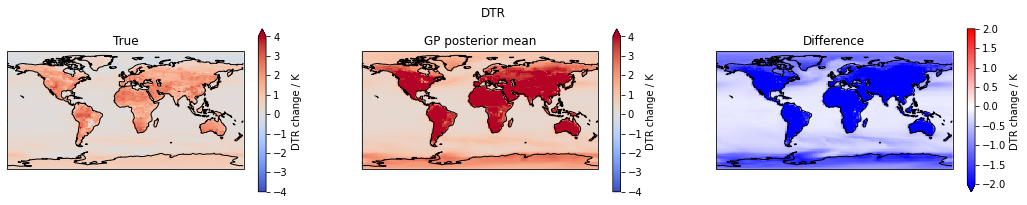

In [29]:
# plotting predictions
divnorm = colors.TwoSlopeNorm(vmin=-2., vcenter=0., vmax=5)
diffnorm = colors.TwoSlopeNorm(vmin=-2., vcenter=0., vmax=2)

## DTR
proj = ccrs.PlateCarree()
fig = plt.figure(figsize=(18, 3))
fig.suptitle('DTR')

# Test
plt.subplot(131, projection=proj)
dtr_truth.sel(time=slice(2050,None)).mean('time').plot(cmap="coolwarm", vmin=-4,
                              cbar_kwargs={"label":"DTR change / K "})
plt.gca().coastlines()
plt.setp(plt.gca(), title='True')

# Emulator
plt.subplot(132, projection=proj)
posterior_dtr_data.sel(time=slice(2050,None)).mean('time').plot(cmap="coolwarm", vmin=-4,
                              cbar_kwargs={"label":"DTR change / K "})
plt.gca().coastlines()
plt.setp(plt.gca(), title='GP posterior mean')

# Difference
difference = dtr_truth - posterior_dtr_data
plt.subplot(133, projection=proj)
difference.sel(time=slice(2050,None)).mean('time').plot(cmap="bwr", norm=diffnorm,
                cbar_kwargs={"label":"DTR change / K "})
plt.gca().coastlines()
plt.setp(plt.gca(), title='Difference')

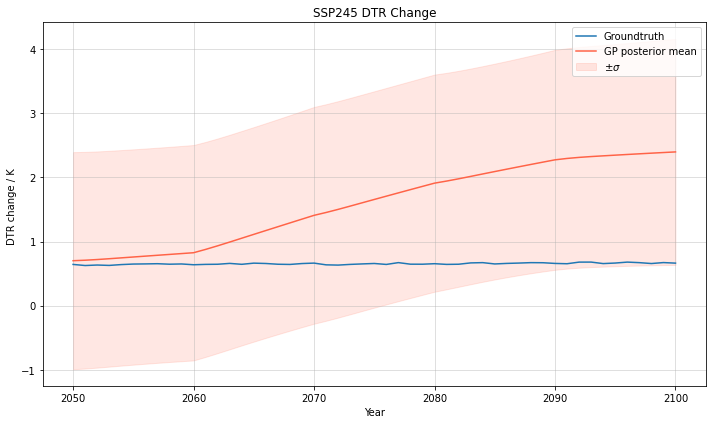

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

time = list(range(2050, 2101))
weights = np.cos(np.deg2rad(dtr_truth.lat))


gt = dtr_truth.sel(time=slice(2050,None)).weighted(weights).mean(['lat', 'lon']).data
mu_post = posterior_dtr_data.sel(time=slice(2050,None)).weighted(weights).mean(['lat', 'lon']).data
sigma_post = posterior_dtr_std_data.sel(time=slice(2050,None)).weighted(weights).mean(['lat', 'lon']).data

ax.plot(time, gt, 
        label='Groundtruth')
ax.plot(time, mu_post, 
        label='GP posterior mean', color='tomato')
ax.fill_between(time, mu_post - sigma_post, mu_post + sigma_post,
                label=r'$\pm\sigma$', color='tomato', alpha=0.15)
ax.set_title("SSP245 DTR Change")
ax.set_xlabel("Year")
ax.set_ylabel("DTR change / K ")
ax.grid(alpha=0.5)
plt.legend()
plt.tight_layout()